In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb # <--- ЗМІНА
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Завантажуємо наш фінальний датасет з усіма ознаками
data_path = '../data/dataset_for_modeling.csv'
df = pd.read_csv(data_path, index_col='DateTime', parse_dates=True)

print("Фінальний датасет успішно завантажено. Розмір:", df.shape)

Фінальний датасет успішно завантажено. Розмір: (4912, 37)


In [3]:
TARGET_COLUMN = 'Global_active_power'
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
split_point = '2010-01-01'
X_train, X_test = X.loc[:split_point], X.loc[split_point:]
y_train, y_test = y.loc[:split_point], y.loc[split_point:]

In [4]:
# Ініціалізуємо модель XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=500, # <--- ЗМІНА
                             learning_rate=0.05,
                             random_state=42,
                             n_jobs=-1,
                             early_stopping_rounds=10) # Зупинити навчання, якщо якість не покращується

print("Починаємо навчання моделі XGBoost...")
# XGBoost може використовувати тестовий набір для ранньої зупинки
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=50) # Друкувати прогрес кожні 50 ітерацій
print("Навчання завершено.")

Починаємо навчання моделі XGBoost...
[0]	validation_0-rmse:52.53216
[50]	validation_0-rmse:15.17407
[100]	validation_0-rmse:13.57599
[150]	validation_0-rmse:13.44236
[174]	validation_0-rmse:13.40538
Навчання завершено.


XGBoost Mean Absolute Error (MAE): 8.89
XGBoost Root Mean Squared Error (RMSE): 13.40


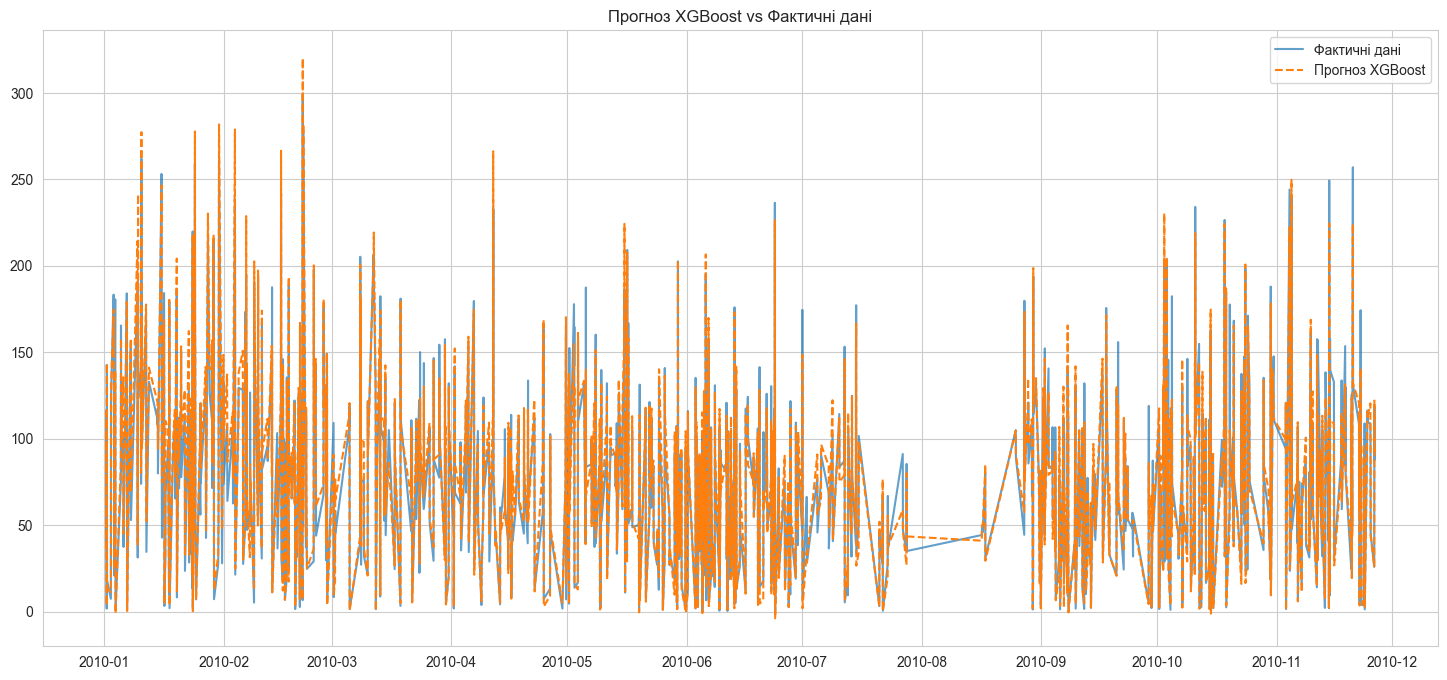

In [5]:
predictions_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
print(f"XGBoost Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"XGBoost Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
plt.plot(y_test.index, y_test, label='Фактичні дані', alpha=0.7)
plt.plot(y_test.index, predictions_xgb, label='Прогноз XGBoost', linestyle='--')
plt.title('Прогноз XGBoost vs Фактичні дані')
plt.legend()
plt.show()

/var/folders/qx/qcg8gq_95sj0ckv67r12b2yw0000gn/T/ipykernel_31220/415535582.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(15), palette='viridis')


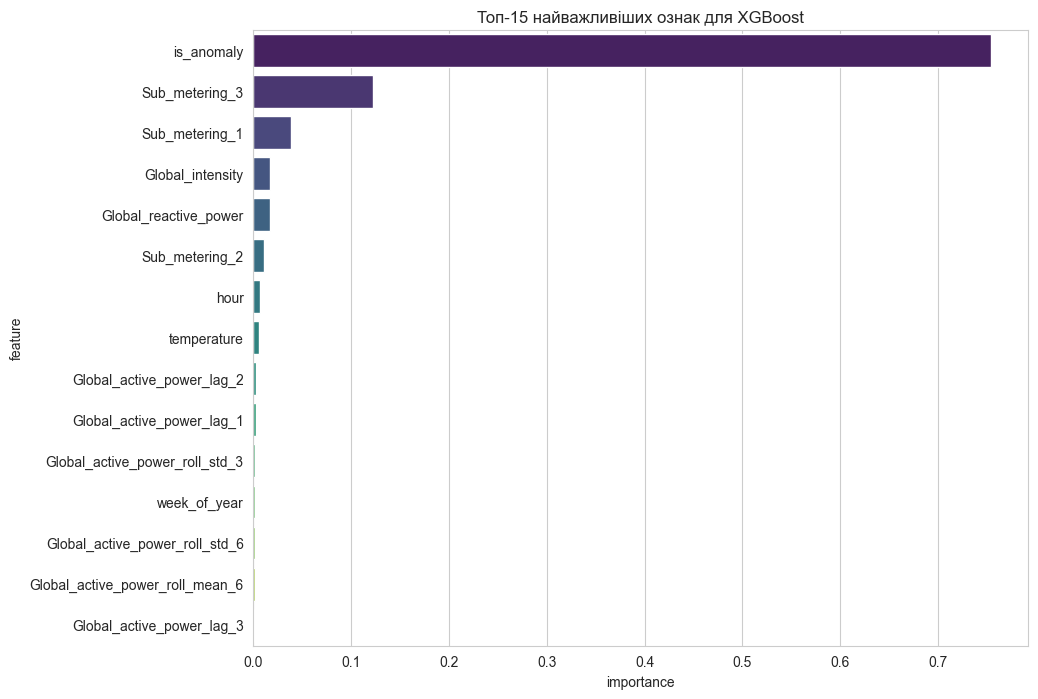

,feature,importance
6,is_anomaly,0.754580
5,Sub_metering_3,0.122177
3,Sub_metering_1,0.038138
2,Global_intensity,0.017193
0,Global_reactive_power,0.016668
4,Sub_metering_2,0.011310
7,hour,0.006907
33,temperature,0.005411
17,Global_active_power_lag_2,0.002737
16,Global_active_power_lag_1,0.002374


In [6]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
# Візуалізуємо топ-15 найважливіших ознак
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15), palette='viridis')
plt.title('Топ-15 найважливіших ознак для XGBoost')
plt.show()

display(feature_importances.head(10))

In [7]:
joblib.dump(xgb_model, '../models/xgboost_model.pkl')
print("Модель XGBoost успішно збережена.")

Модель XGBoost успішно збережена.
